### 1. Importar librerias


In [32]:
import sys
import os

In [33]:
sys.path.append(os.path.abspath(".."))

In [34]:
import pandas as pd
from src.data_processing import load_data
import matplotlib.pyplot as plt
import seaborn as sns


### 2. Cargar dataframe limpio

In [35]:
# 1. Crear variable para ruta archivo
input_path = "../data/interim/df_master_clean.csv"


# 2. Cargar el dataframe limpio y convertir columnas en tipo de datos datetime
df_master_clean = pd.read_csv(input_path, 
                        parse_dates=['order_purchase_timestamp', 
                                     'order_approved_at', 
                                     'order_delivered_carrier_date',
                                     'order_delivered_customer_date',
                                     'order_estimated_delivery_date',
                                     'shipping_limit_date',
                                     'review_creation_date',
                                     'review_answer_timestamp'])

df_master_clean.info()

C:\Users\william\AppData\Local\Temp\ipykernel_11708\2413652619.py:6: DtypeWarning: Columns (32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_master_clean = pd.read_csv(input_path,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119137 entries, 0 to 119136
Data columns (total 48 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   order_id                            119137 non-null  object        
 1   customer_id                         119137 non-null  object        
 2   order_status                        119137 non-null  object        
 3   order_purchase_timestamp            119137 non-null  datetime64[ns]
 4   order_approved_at                   118960 non-null  datetime64[ns]
 5   order_delivered_carrier_date        117051 non-null  datetime64[ns]
 6   order_delivered_customer_date       115718 non-null  datetime64[ns]
 7   order_estimated_delivery_date       119137 non-null  datetime64[ns]
 8   order_item_id                       118304 non-null  float64       
 9   product_id                          118304 non-null  object        
 10  seller_i

### 3. Analisis exploratorio EDA
a) Ananlisis de Recencia (inactividad desde la ultima compra.)

In [36]:
# Identificar la fecha del ultimo pedido registrado en el DataSet,
# fecha base para determinar que tan antiguo es el comportamiento de cada cliente.

# 1. Hallar la fecha maxima(el hoy del dataset)
fecha_maxima_base = df_master_clean['order_purchase_timestamp'].max()

# 2. Mostrar la fecha de referencia.
print(f"La fecha de referencia (Punto Cero) es: {fecha_maxima_base}")

# 3.Ver el rango total de tiempo
fecha_minima_base = df_master_clean['order_purchase_timestamp'].min()
print(f"El dataset cubre desde {fecha_minima_base} hasta {fecha_maxima_base}")

La fecha de referencia (Punto Cero) es: 2018-10-17 17:30:18
El dataset cubre desde 2016-09-04 21:15:19 hasta 2018-10-17 17:30:18


In [37]:
# Crear una tabla temporal de clientes unicos con la ultima fecha en que realizo una compra.
df_clientes_fecha_ultima_compra = df_master_clean.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

# Renombrar la columna para que sea más clara
df_clientes_fecha_ultima_compra = df_clientes_fecha_ultima_compra.rename(columns={'order_purchase_timestamp': 'ultima_compra'})

# Ver el resultado
print(f"Ahora tienes {df_clientes_fecha_ultima_compra.shape[0]} clientes unicos.")
df_clientes_fecha_ultima_compra.head()

Ahora tienes 96096 clientes unicos.


,customer_unique_id,ultima_compra
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [38]:
# 1. Restar la fecha base con las ultimas fechas de compras para obtener los dias de inactividad de cada cliente.
df_clientes_fecha_ultima_compra['diferecia_tiempo'] = fecha_maxima_base - df_clientes_fecha_ultima_compra['ultima_compra']

# 2. Convertir la diferencia a numeros enteros de dias.
df_clientes_fecha_ultima_compra['dias_inactividad'] = df_clientes_fecha_ultima_compra['diferecia_tiempo'].dt.days

print(df_clientes_fecha_ultima_compra[['customer_unique_id', 'dias_inactividad']].head())

                 customer_unique_id  dias_inactividad
0  0000366f3b9a7992bf8c76cfdf3221e2               160
1  0000b849f77a49e4a4ce2b2a4ca5be3f               163
2  0000f46a3911fa3c0805444483337064               585
3  0000f6ccb0745a6a4b88665a16c9f078               369
4  0004aac84e0df4da2b147fca70cf8255               336


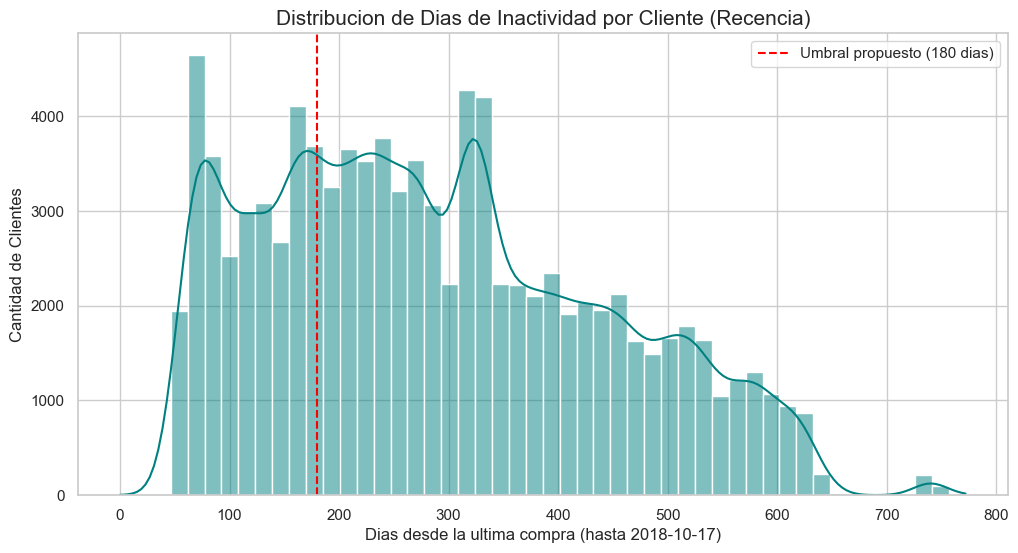

In [39]:
# Crear grafico de histograma para visualizar los datos.

# 1. Configurar el estilo visual
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))

# 2. Crear el histograma
sns.histplot(df_clientes_fecha_ultima_compra['dias_inactividad'], bins=50, kde=True, color='teal')

# 3. Añadir titulos y etiquetas.
plt.title('Distribucion de Dias de Inactividad por Cliente (Recencia)', fontsize=15)
plt.xlabel('Dias desde la ultima compra (hasta 2018-10-17)', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)

# 4. Dibujar una linea roja en los 180 dias par visualizar el posible umbral
plt.axvline(180, color='red', linestyle='--', label='Umbral propuesto (180 dias)')
plt.legend()

plt.show()



b) Analisis de Frecuencia de compra: para ver cuantos de estos clientes son compradores recurrentes vs. compradores de una sola vez.

In [43]:
# 1. Calcular la cantidad de pedidos por cada cliente único
frecuencia_pedidos = df_master_clean.groupby('customer_unique_id')['order_id'].nunique().reset_index()
frecuencia_pedidos.columns = ['customer_unique_id', 'total_pedidos']

# 2. Ver la distribución en porcentajes
distribucion_frecuencia = frecuencia_pedidos['total_pedidos'].value_counts(normalize=True).sort_index() * 100

print("Distribución de lealtad de clientes (%):")
print(distribucion_frecuencia.head(5))

Distribución de lealtad de clientes (%):
total_pedidos
1    96.881244
2     2.856518
3     0.211247
4     0.031219
5     0.008325
Name: proportion, dtype: float64


C:\Users\william\AppData\Local\Temp\ipykernel_11708\1409334147.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


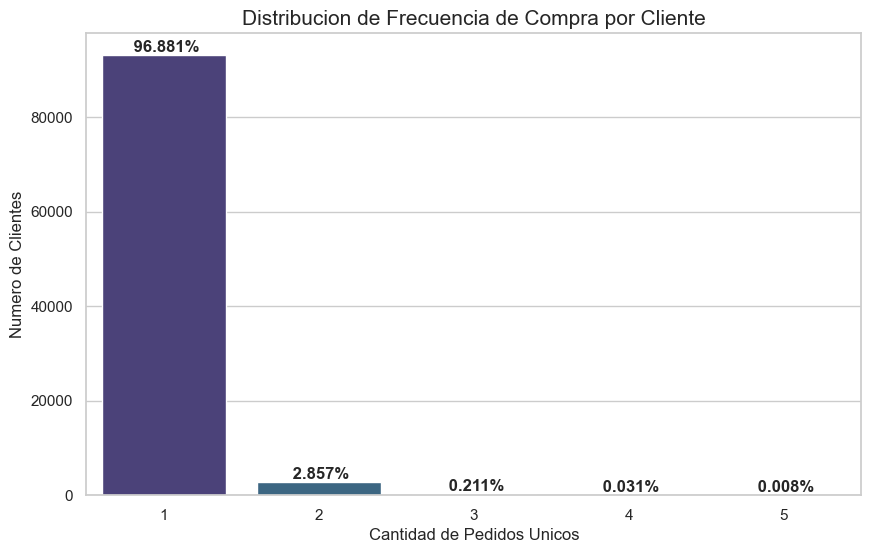

In [45]:
# 1. Preparar los datos (usando el conteo anterior)
# Vamos a ver solo hasta los clientes con 5 pedidos para que el grafico sea claro

data_grafico = frecuencia_pedidos[frecuencia_pedidos['total_pedidos'] <= 5] 

plt.figure(figsize=(10,6))
ax = sns.countplot(
    data=data_grafico,
    x='total_pedidos',
    palette='viridis'
    )

# 2. Añadir porcentajes sobre las barras.
total = len(frecuencia_pedidos)
for p in ax.patches:
    porcentaje = f'{100 * p.get_height() / total: .3f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(porcentaje, (x,y), ha='center', va='bottom', fontsize=12, fontweight='bold' )

# 3. Añadir titulos
plt.title('Distribucion de Frecuencia de Compra por Cliente', fontsize=15)
plt.xlabel('Cantidad de Pedidos Unicos', fontsize=12)
plt.ylabel('Numero de Clientes', fontsize=12)
plt.show()

In [46]:
# 1. Indentificar a los heavy Users.
# Ver quienes son los clientes que mas compraron en la historia de Olist.

# Ordenar la tabla de frecuencia para ver a los clientes con mas pedidos.
top_clientes = frecuencia_pedidos.sort_values(by='total_pedidos', ascending=False).head(10)
print("Top 10 clientes con mayor numero de compras: ")
print(top_clientes)

Top 10 clientes con mayor numero de compras: 
                     customer_unique_id  total_pedidos
52973  8d50f5eadf50201ccdcedfb9e2ac8455             17
23472  3e43e6105506432c953e165fb2acf44c              9
10354  1b6c7548a2a1f9037c1fd3ddfed95f33              7
37797  6469f99c1f9dfae7733b25662e7f1782              7
76082  ca77025e7201e3b30c44b472ff346268              7
27043  47c1a3033b8b77b3ab6e109eb4d5fdf3              6
7175   12f5d6e1cbf93dafd9dcc19095df0b3d              6
37585  63cfc61cee11cbe306bff5857d00bfe4              6
82883  dc813062e0fc23409cd255f7f53c7074              6
83540  de34b16117594161a6a89c50b289d35a              6


c) Analisis de Calidad y Satisfaccion

Distribucion de puntajes de reseñas: 
review_score
1.0    13.056543
2.0     3.522939
3.0     8.374810
4.0    18.890300
5.0    56.155409
Name: proportion, dtype: float64


C:\Users\william\AppData\Local\Temp\ipykernel_11708\2519310206.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_master_clean, x='review_score', palette='RdYlGn')


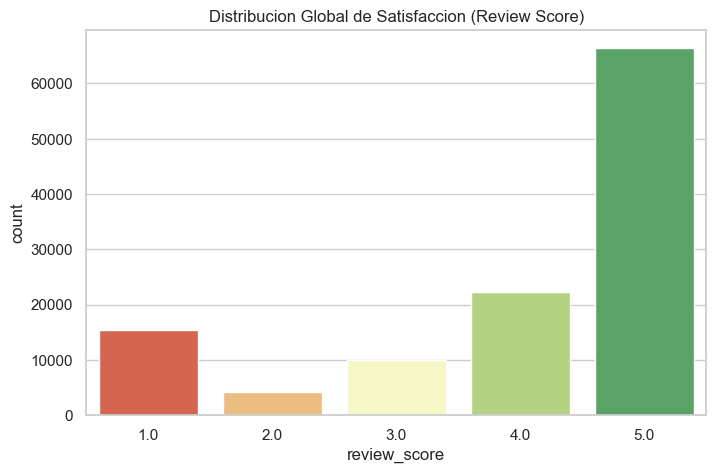

In [50]:
# 1. Distribucion de las reseñas.
print("Distribucion de puntajes de reseñas: ")
print(df_master_clean['review_score'].value_counts(normalize=True).sort_index() * 100)

# 2. Promedio de reseña por cliente (para futura tabla de clientes)
satisfaccion_clientes = df_master_clean.groupby('customer_unique_id')['review_score'].mean().reset_index()

# 3. Visualizacion rapida.
plt.figure(figsize=(8,5))
sns.countplot(data=df_master_clean, x='review_score', palette='RdYlGn')
plt.title('Distribucion Global de Satisfaccion (Review Score)')
plt.show()


d) Ver si la montaña de inactividad de los clientes con 1 estrella esta mas desplazada hacia la derecha (mas inactivos) que la de los clientes de 5 estrellas.

C:\Users\william\AppData\Local\Temp\ipykernel_11708\2210557863.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cruce_sat, x='review_score_redondeado', y='dias_inactividad', palette='RdYlGn')


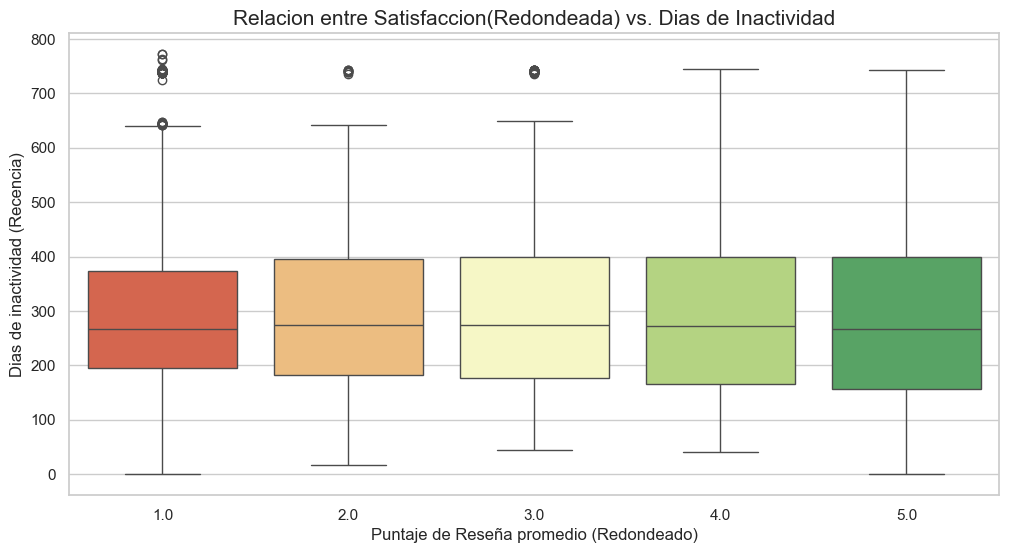

In [52]:
# 1. Agrupara satisfaccion por cliente (promedio)
satisfaccion_por_cliente = df_master_clean.groupby('customer_unique_id')['review_score'].mean().reset_index()

# 2. Unir con la tabla de inactividad.
df_cruce_sat = pd.merge(df_clientes_fecha_ultima_compra, satisfaccion_por_cliente, on='customer_unique_id')

# 3. Redondear el promedio para tener categorias limpias (1, 2, 3, 4, 5)
df_cruce_sat['review_score_redondeado'] = df_cruce_sat['review_score'].round()

#3. Crear un grafico de boxplot para comparar
plt.figure(figsize=(12,6))
sns.boxplot(data=df_cruce_sat, x='review_score_redondeado', y='dias_inactividad', palette='RdYlGn')

plt.title('Relacion entre Satisfaccion(Redondeada) vs. Dias de Inactividad', fontsize=15)
plt.xlabel('Puntaje de Reseña promedio (Redondeado)', fontsize=12)
plt.ylabel('Dias de inactividad (Recencia)', fontsize=12)
plt.show()